# Azure OpenAI benchmarking

Serge Retkowsky | 08-Jul-2024

<img src="img/logobench.jpg" width=600>

- This notebook will do some benchmarks tests on your Azure OpenAI models on PayGo and/or PTU.
- This notebook is using the GitGub repo from Microsoft: https://github.com/Azure/azure-openai-benchmark

### Predefined scenarios
<img src="img/image1.jpg">

### Profiles
<img src="img/image2.jpg">

### Generated metrics
<img src="img/image3.jpg">


- When running a test with **retry=none**, any throttled request will be treated as throttled and a new request will be made to replace it, with the start time of the replacement request being reset to a newer time. If the resource being tested starts returning 429s, **then any latency metrics from this tool will only represent the values of the final successful request**, without also including the time that was spent retrying to resource until a successful response was received (which may not be representative of the real-world user experience). This setting should be used when the workload being tested results is within the resource's capacity and no throttling occurs, or where you are looking to understand what percentage of requests to a PTU instance might need to be diverted to a backup resource, such as during periods of peak load which require more throughput than the PTU resource can handle.

- When running a test with **retry=exponential**, any failed or throttled request will be retried with exponential backoff, up to a **max of 60 seconds**. While it is always recommended to deploy backup AOAI resources for use-cases that will experience periods of high load, **this setting may be useful for trying to simulate a scenario where no backup resource is available**, and where throttled or failed requests must still be fulfilled by the resource. **In this case, the TTFT and e2e latency metrics will represent the time from the first throttled request to the time that the final request was successful, and may be more reflective of the total time that an end user could spend waiting for a response**, e.g. in a chat application. Use this option in situations where you want to understand the latency of requests which are throttled and need to be retried on the same resource, and the how the total latency of a request is impacted by multiple request retries.

As a practical example, if a PTU resource is tested beyond 100% capacity and starts returning 429s:
- With **retry=none** the TTFT and e2e latency statistics will remain stable (and very low), since only the successful requests will be included in the metrics. Number of throttled requests will be relatively high.
- With **retry=exponential**, the TTFT/e2e latency metrics will increase (potentially up to the max of 60 seconds), while the number of throttled requests will remain lower (since a request is only treated as throttled after 60 seconds, regardless of how many attempts were made within the retry period).
Total throughput values (RPM, TPM) may be lower when retry=none if rate limiting is applied.

**As a best practice, any PTU resource should be deployed with a backup PayGO resource for times of peak load. As a result, any testing should be conducted with the values suggested in the AOAI capacity calculator (within the AI Azure Portal) to ensure that throttling does not occur during testing.**

In [68]:
#%pip install -U kaleido

In [69]:
import datetime
import json
import matplotlib.pyplot as plt
import openai
import os
import pandas as pd
import plotly.express as px
import pytz
import requests
import seaborn as sns
import shutil
import subprocess
import sweetviz as sv
import sys
import time

from datetime import datetime as DT
from dotenv import load_dotenv
from IPython.display import FileLink
from openai import AzureOpenAI
from plotly.subplots import make_subplots
%matplotlib inline

In [70]:
local_tz = DT.now(pytz.timezone(requests.get("https://ipinfo.io").json()["timezone"])).strftime("%d-%b-%Y %H:%M:%S")
print(f"Today is {local_tz}")

Today is 08-Jul-2024 13:56:56


In [71]:
print(f"Python version: {sys.version}")
print(f"OpenAI version: {openai.__version__}")

Python version: 3.10.11 (main, May 16 2023, 00:28:57) [GCC 11.2.0]
OpenAI version: 1.35.1


### To maximize cells output

In [72]:
%%javascript Python 
OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

## 1. Settings

In [73]:
load_dotenv("azure.env")

True

In [74]:
HOME = os.getcwd()
print(f"Current directory is: {HOME}")

Current directory is: /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow9/code/Users/seretkow/AOAI benchmarks


In [75]:
# Dir to save all the generated results
RES_DIR = "results"

os.makedirs(RES_DIR, exist_ok=True)

local_tz = DT.now(pytz.timezone(requests.get("https://ipinfo.io").json()["timezone"])).strftime("%d%b%Y_%H%M%S")
RESULTS_DIR = f"{RES_DIR}/results_{local_tz}"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [76]:
ZIP_DIR = "zip"

os.makedirs(ZIP_DIR, exist_ok=True)

In [77]:
# Dir to download the github repo from https://github.com/Azure/azure-openai-benchmark
DIR_BENCHMARK = 'azure-openai-benchmark'

#shutil.rmtree(DIR_BENCHMARK)
#!git clone https://github.com/Azure/azure-openai-benchmark

In [78]:
os.chdir(DIR_BENCHMARK)

In [79]:
#!pip install -r requirements.txt

In [80]:
print(f"Current directory is: {os.getcwd()}")

Current directory is: /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow9/code/Users/seretkow/AOAI benchmarks/azure-openai-benchmark


## 2. Models settings

In [81]:
# Model 1
MODEL1 = "gpt-4o"
# Label
MODEL1_LABEL = "gpt-4o PAYGO"

# Model endpoint and key
ENDPOINT1 = os.getenv("ENDPOINT1")
KEY1 = os.getenv("KEY1")

In [82]:
# Model 2
MODEL2 = "gpt-4-32k"
# Label
MODEL2_LABEL = "gpt-4-32k PAYGO"

# Model endpoint and key
ENDPOINT2 = os.getenv("ENDPOINT2")
KEY2 = os.getenv("KEY2")

In [83]:
print(f"This notebook will do some Azure OpenAI benchmarks on models: {MODEL1} and {MODEL2}")

This notebook will do some Azure OpenAI benchmarks on models: gpt-4o and gpt-4-32k


In [84]:
metrics_labels = {
    "time": "Time offset in seconds since the start of the test",
    "rpm": "Successful Requests Per Minute",
    "tpm": "Tokens Per Minute",
    "processing": "Total number of requests currently being processed by the endpoint",
    "completed": "Total number of completed requests",
    "failures": "Total number of failed requests out of requests",
    "throttled": "Total number of throttled requests out of requests",
    "requests": "Deprecated in favor of completed field (output values of both fields are the same)",
    "ttft_avg": "Average time in seconds from the beginning of the request until the first token was received",
    "ttft_95th": "95th percentile of time in seconds from the beginning of the request until the first token was received",
    "tbt_avg": "Average time in seconds between two consecutive generated tokens",
    "tbt_95th": "95th percentile of time in seconds between two consecutive generated tokens",
    "e2e_avg": "Average end to end request time",
    "e2e_95th": "95th percentile of end to end request time",
    "util_avg": "Average deployment utilization percentage as reported by the service",
    "util_95th": "95th percentile of deployment utilization percentage as reported by the service"
}


## 3. Syntax and available options from the Microsoft benchmark tool

In [85]:
!python -m benchmark.bench load --help

usage: bench.py load [-h] [-a API_VERSION] [-k API_KEY_ENV] [-c CLIENTS]
                     [-n REQUESTS] [-d DURATION] [-r RATE]
                     [-w AGGREGATION_WINDOW]
                     [-s {balanced,context,generation,custom}]
                     [-p CONTEXT_TOKENS] [-m MAX_TOKENS] [-i COMPLETIONS]
                     [--frequency-penalty FREQUENCY_PENALTY]
                     [--presence-penalty PRESENCE_PENALTY]
                     [--temperature TEMPERATURE] [--top-p TOP_P]
                     [-f {jsonl,human}] [-t {none,exponential}] -e DEPLOYMENT
                     api_base_endpoint

positional arguments:
  api_base_endpoint     Azure OpenAI deployment base endpoint.

optional arguments:
  -h, --help            show this help message and exit
  -a API_VERSION, --api-version API_VERSION
                        Set OpenAI API version.
  -k API_KEY_ENV, --api-key-env API_KEY_ENV
                        Environment variable that contains the API KEY.
  -c CLIENTS,

> Documentation: https://github.com/Azure/azure-openai-benchmark

## 4. Quick test using

In [86]:
os.environ['OPENAI_API_KEY'] = KEY1

In [87]:
print(f"Let's use the {MODEL1} model")

Let's use the gpt-4o model


In [88]:
command = [
    'python', '-m', 'benchmark.bench', 'load',
    '--deployment', MODEL1,  # Model to use
    '--rate', '30',
    '--retry', 'exponential',  # Retry
    '--duration', '30',
    ENDPOINT1 # Model endpoint to use
]

# Run the command
start = time.time()
now = datetime.datetime.today()
print(f"{now} Running benchmarks for model {MODEL1}...")
result = subprocess.run(command, capture_output=True, text=True)
elapsed = time.time() - start
print("Done")
print("Elapsed time: " + time.strftime(
    "%H:%M:%S.{}".format(str(elapsed % 1)[2:])[:15], time.gmtime(elapsed)))

2024-07-08 11:56:57.711111 Running benchmarks for model gpt-4o...
Done
Elapsed time: 00:00:37.445420


In [89]:
print("\033[1;31;34m")
print(result.stdout)


2024-07-08 11:56:59 rpm: n/a   processing: 2    completed: 0     failures: 0    throttled: 0    requests: 0     tpm: 0      ttft_avg: n/a    ttft_95th: n/a    tbt_avg: n/a    tbt_95th: n/a    e2e_avg: n/a    e2e_95th: n/a    util_avg: n/a    util_95th: n/a   
2024-07-08 11:57:00 rpm: n/a   processing: 2    completed: 0     failures: 0    throttled: 0    requests: 0     tpm: 0      ttft_avg: n/a    ttft_95th: n/a    tbt_avg: n/a    tbt_95th: n/a    e2e_avg: n/a    e2e_95th: n/a    util_avg: n/a    util_95th: n/a   
2024-07-08 11:57:01 rpm: n/a   processing: 3    completed: 0     failures: 0    throttled: 0    requests: 0     tpm: 0      ttft_avg: n/a    ttft_95th: n/a    tbt_avg: n/a    tbt_95th: n/a    e2e_avg: n/a    e2e_95th: n/a    util_avg: n/a    util_95th: n/a   
2024-07-08 11:57:02 rpm: n/a   processing: 3    completed: 0     failures: 0    throttled: 0    requests: 0     tpm: 0      ttft_avg: n/a    ttft_95th: n/a    tbt_avg: n/a    tbt_95th: n/a    e2e_avg: n/a    e2e_95th: n

In [90]:
print("\033[1;31;34m")
print(result.stderr)


2024-07-08 11:56:58 INFO     using shape profile balanced: context tokens: 500, max tokens: 500
2024-07-08 11:56:58 INFO     warming up prompt cache
2024-07-08 11:56:58 INFO     starting load...
2024-07-08 11:57:28 INFO     waiting for 16 requests to drain
2024-07-08 11:57:35 INFO     finished load test



## 5. Advanced testing with model 1

In [91]:
print(f"Benchmarks for model {MODEL1}")

Benchmarks for model gpt-4o


In [92]:
# With output file generation
OUTPUT_FILE = os.path.join(HOME, RESULTS_DIR, f"benchmarks_{MODEL1_LABEL}_{local_tz}.txt")

command = [
    'python', '-m', 'benchmark.bench', 'load',
    '--deployment', MODEL1,  # Model to use
    '--rate', '15',  # RPM
    '--duration', '180',  # Duration in seconds (should be > 30 secs)
    '--shape', 'custom',  # Custom request shape
    '--context-tokens', '500',  # Context tokens
    '--max-tokens', '500',  # Max tokens
    '--retry', 'exponential',  # Retry
    '--output-format', 'human',  # Output format
    ENDPOINT1  # Model endpoint to use
]

# Running the benchmarks
start = time.time()
now = datetime.datetime.today()
print(f"{now} Running benchmarks for model {MODEL1}...")
result = subprocess.run(command, capture_output=True, text=True)
elapsed = time.time() - start

# Saving the results into a file
with open(OUTPUT_FILE, 'w') as f:
    f.write(result.stdout)

print(f"Benchmark output saved to file {OUTPUT_FILE}")
now = datetime.datetime.today()
print("End:", now)
print("Elapsed time: " + time.strftime(
    "%H:%M:%S.{}".format(str(elapsed % 1)[2:])[:15], time.gmtime(elapsed)))

2024-07-08 11:57:35.213858 Running benchmarks for model gpt-4o...
Benchmark output saved to file /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow9/code/Users/seretkow/AOAI benchmarks/results/results_08Jul2024_135656/benchmarks_gpt-4o PAYGO_08Jul2024_135656.txt
End: 2024-07-08 12:00:42.551479
Elapsed time: 00:03:07.271569


In [93]:
# Define the columns to read and their corresponding indices in the file
columns = {
    'timestamp': (0, 2),
    'rpm': 3,
    'processing': 5,
    'completed': 7,
    'failures': 9,
    'throttled': 11,
    'requests': 13,
    'tpm': 15,
    'ttft_avg': 17,
    'ttft_95th': 19,
    'tbt_avg': 21,
    'tbt_95th': 23,
    'e2e_avg': 25,
    'e2e_95th': 27,
    'util_avg': 29,
    'util_95th': 31
}

data = {key: [] for key in columns.keys()}

# Reading file
with open(OUTPUT_FILE, 'r') as file:
    for line in file:
        fields = line.strip().split()
        for key, idx in columns.items():
            if isinstance(idx, tuple):
                value = ' '.join(fields[idx[0]:idx[1]])
            else:
                value = fields[idx]
            data[key].append(value)

df1 = pd.DataFrame(data)
df1 = df1.replace('n/a', 0)

In [94]:
df1

,timestamp,rpm,processing,completed,failures,throttled,requests,tpm,ttft_avg,ttft_95th,tbt_avg,tbt_95th,e2e_avg,e2e_95th,util_avg,util_95th
0,2024-07-08 11:57:37,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2024-07-08 11:57:38,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2024-07-08 11:57:39,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2024-07-08 11:57:40,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2024-07-08 11:57:41,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,2024-07-08 12:00:38,12.0,2,41,0,0,41,12048.0,0.207,0.581,0.012,0.014,6.46,7.656,0,0
182,2024-07-08 12:00:39,13.0,1,42,0,0,42,13052.0,0.2,0.543,0.012,0.014,6.47,7.654,0,0
183,2024-07-08 12:00:40,12.0,1,42,0,0,42,12048.0,0.206,0.581,0.012,0.014,6.47,7.654,0,0
184,2024-07-08 12:00:41,12.0,1,42,0,0,42,12048.0,0.206,0.581,0.012,0.014,6.47,7.654,0,0


In [95]:
int_columns = ['failures', 'throttled']
float_columns = ['rpm', 'tpm', 'ttft_avg', 'ttft_95th', 'tbt_avg', 'tbt_95th', 'e2e_avg', 'e2e_95th', ]
df1[int_columns] = df1[int_columns].astype(int)
df1[float_columns] = df1[float_columns].astype(float)
df1['model'] = MODEL1

cols_to_plot = int_columns + float_columns

In [96]:
df1

,timestamp,rpm,processing,completed,failures,throttled,requests,tpm,ttft_avg,ttft_95th,tbt_avg,tbt_95th,e2e_avg,e2e_95th,util_avg,util_95th,model
0,2024-07-08 11:57:37,0.0,2,0,0,0,0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0,0,gpt-4o
1,2024-07-08 11:57:38,0.0,2,0,0,0,0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0,0,gpt-4o
2,2024-07-08 11:57:39,0.0,2,0,0,0,0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0,0,gpt-4o
3,2024-07-08 11:57:40,0.0,2,0,0,0,0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0,0,gpt-4o
4,2024-07-08 11:57:41,0.0,3,0,0,0,0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0,0,gpt-4o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,2024-07-08 12:00:38,12.0,2,41,0,0,41,12048.0,0.207,0.581,0.012,0.014,6.460,7.656,0,0,gpt-4o
182,2024-07-08 12:00:39,13.0,1,42,0,0,42,13052.0,0.200,0.543,0.012,0.014,6.470,7.654,0,0,gpt-4o
183,2024-07-08 12:00:40,12.0,1,42,0,0,42,12048.0,0.206,0.581,0.012,0.014,6.470,7.654,0,0,gpt-4o
184,2024-07-08 12:00:41,12.0,1,42,0,0,42,12048.0,0.206,0.581,0.012,0.014,6.470,7.654,0,0,gpt-4o


In [97]:
df1.shape

(186, 17)

In [98]:
df1.describe()

,rpm,failures,throttled,tpm,ttft_avg,ttft_95th,tbt_avg,tbt_95th,e2e_avg,e2e_95th,util_avg,util_95th
count,186.000000,186.0,186.0,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.0,186.0
mean,12.439785,0.0,0.0,12491.344086,0.156409,0.251237,0.012043,0.013941,6.236140,7.113452,0.0,0.0
std,2.389465,0.0,0.0,2400.524549,0.041416,0.122545,0.002259,0.002739,1.145562,1.354903,0.0,0.0
min,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,12.000000,0.0,0.0,12048.000000,0.136000,0.179000,0.012000,0.014000,6.418000,7.145000,0.0,0.0
50%,13.000000,0.0,0.0,13052.000000,0.148000,0.232000,0.012000,0.015000,6.458000,7.553000,0.0,0.0
75%,13.000000,0.0,0.0,13052.000000,0.175000,0.260000,0.013000,0.015000,6.494000,7.639000,0.0,0.0
max,17.100000,0.0,0.0,17212.000000,0.247000,0.581000,0.013000,0.016000,6.587000,7.682000,0.0,0.0


### 5.1 Lineplots using Plotly

In [99]:
for col in cols_to_plot:
    fig = px.line(df1,
                  x=df1.index,
                  y=df1[col],
                  title=f'{col} for model {MODEL1} ({metrics_labels[col]})',
                 )
    fig.show()
    fig.write_image(os.path.join(HOME, RESULTS_DIR, f"{MODEL1_LABEL}_lineplot_{col}_{local_tz}.jpg"))

### 5.2 Lineplots using Seaborn

In [100]:
df1 = df1.reset_index()

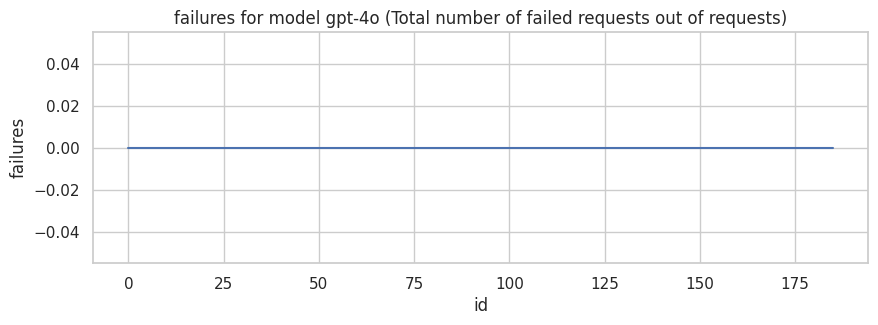

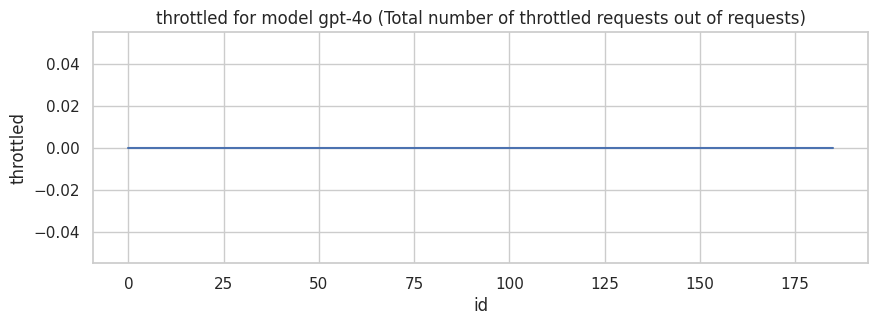

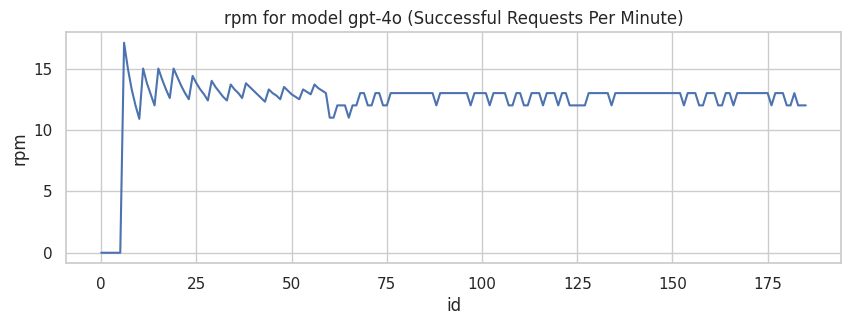

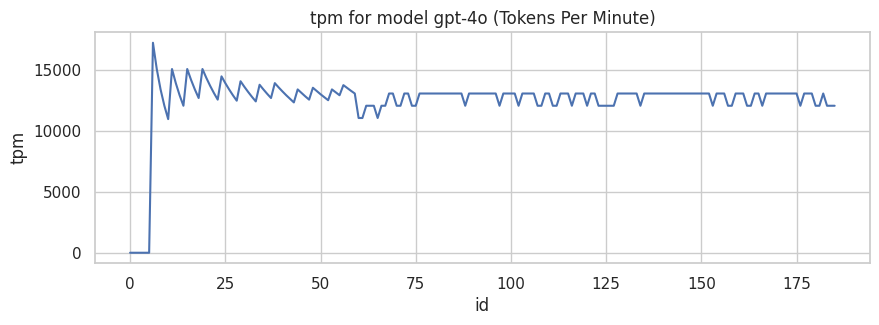

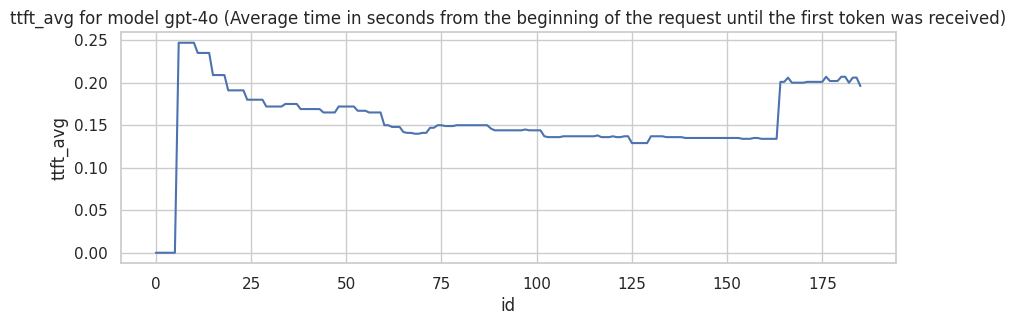

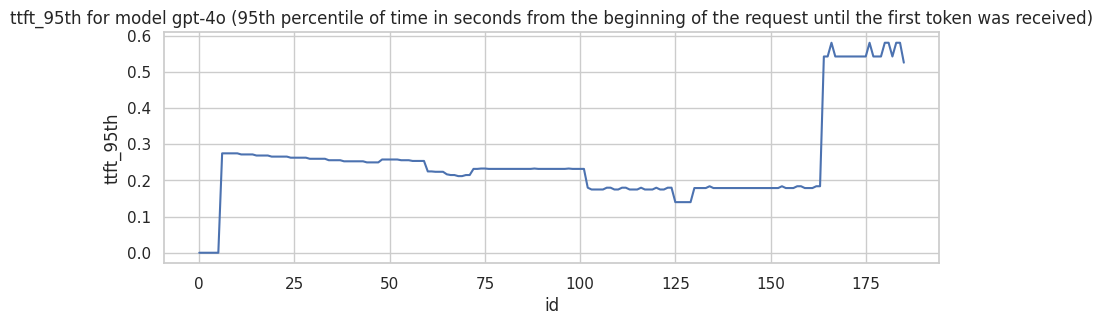

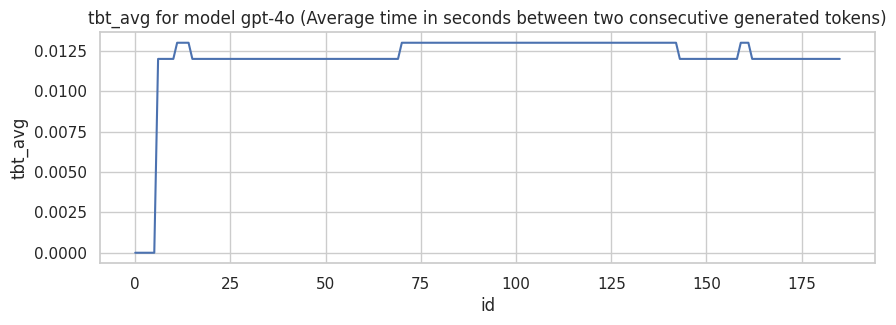

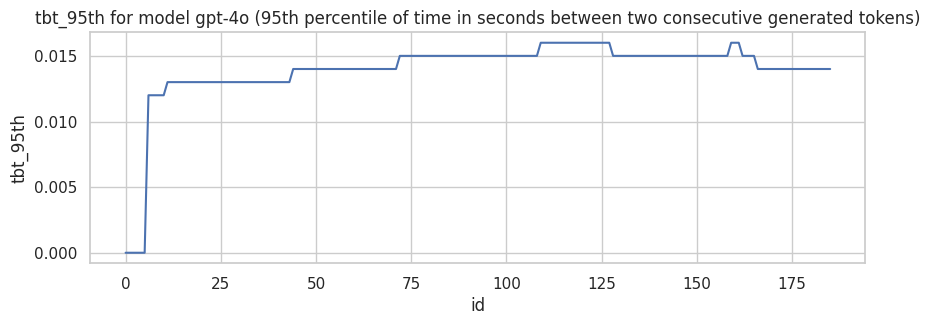

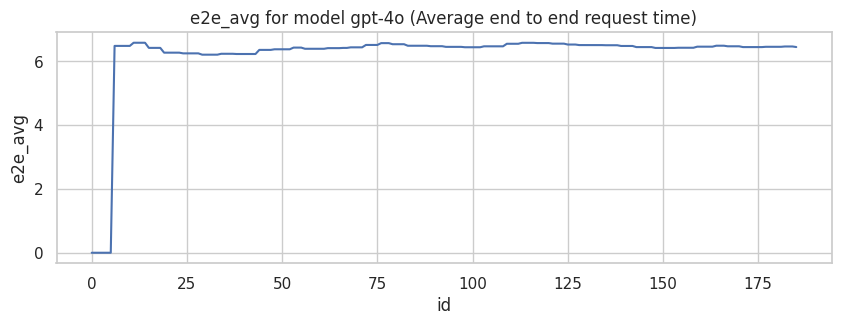

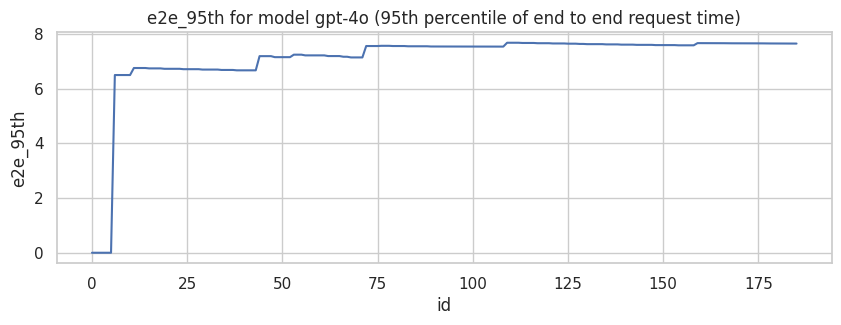

In [101]:
sns.set(style="whitegrid")

for col in cols_to_plot:
    plt.figure(figsize=(10, 3))
    sns.lineplot(data=df1, x='index', y=col)
    plt.title(f'{col} for model {MODEL1} ({metrics_labels[col]})')
    plt.xlabel('id')
    plt.ylabel(col)
    plt.show()

### 5.3 Boxplots using Plotly

In [102]:
for col in cols_to_plot:
    fig = px.box(df1, y=df1[col], title=f'{col} for model {MODEL1} ({metrics_labels[col]})')
    fig.show()
    fig.write_image(os.path.join(HOME, RESULTS_DIR, f"{MODEL1_LABEL}_boxplot_{col}_{local_tz}.jpg"))

### 5.4 Boxplots using Seaborn

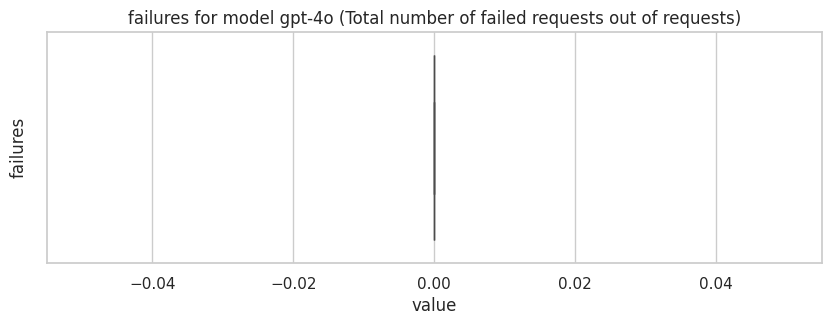

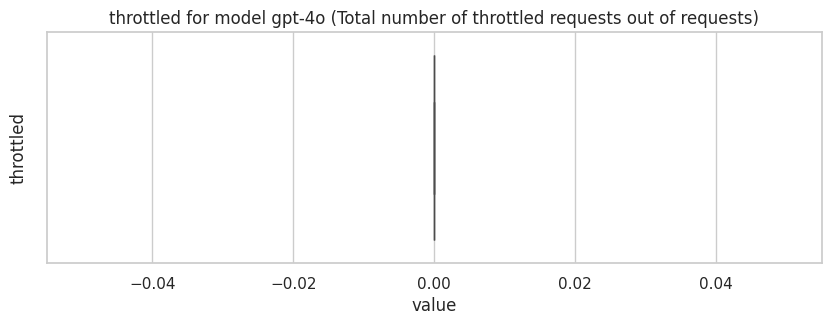

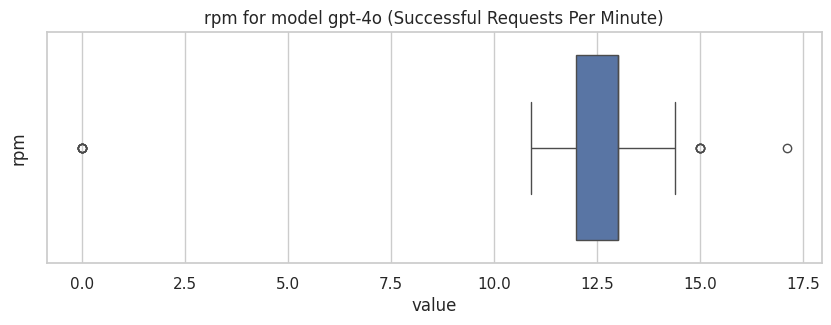

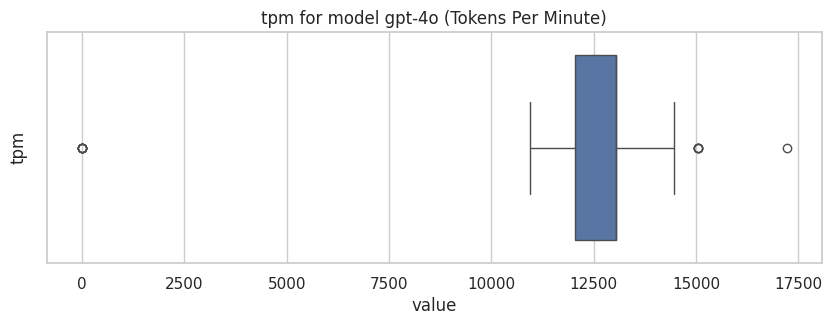

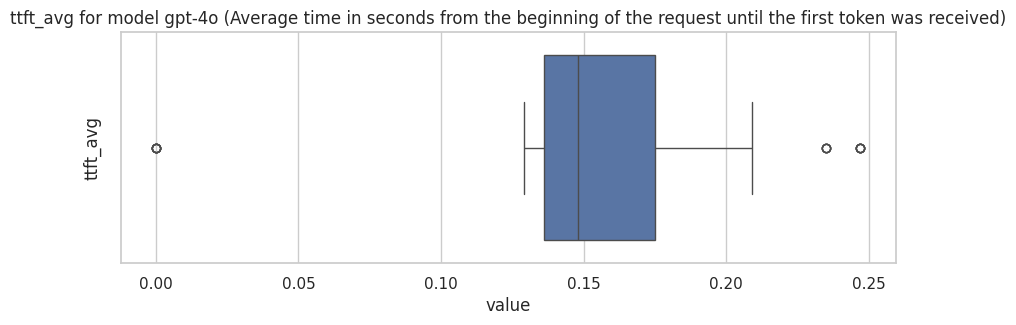

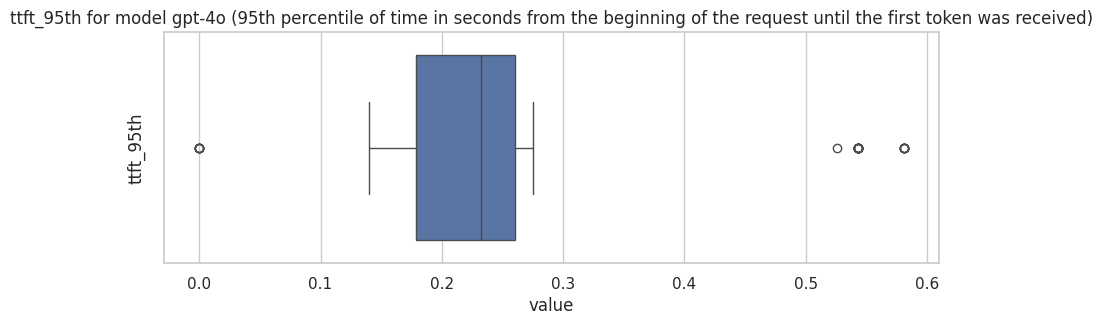

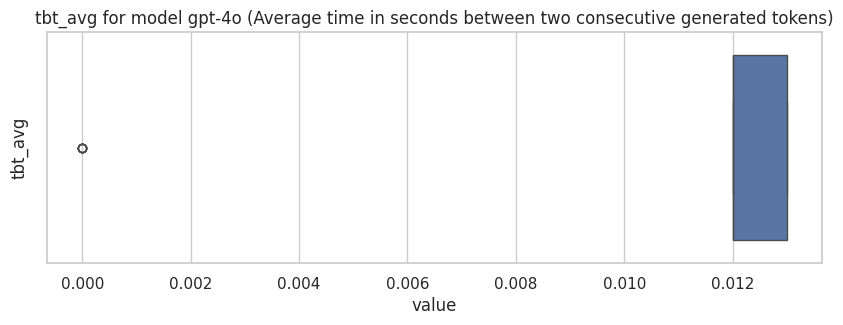

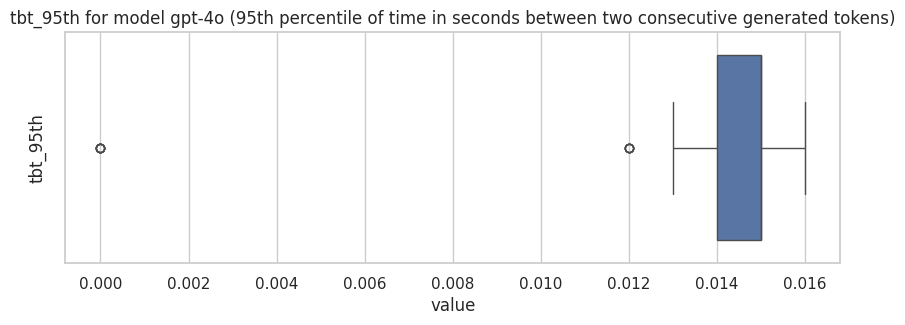

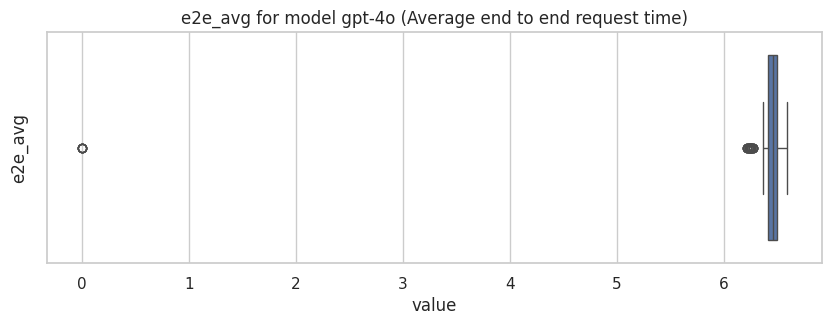

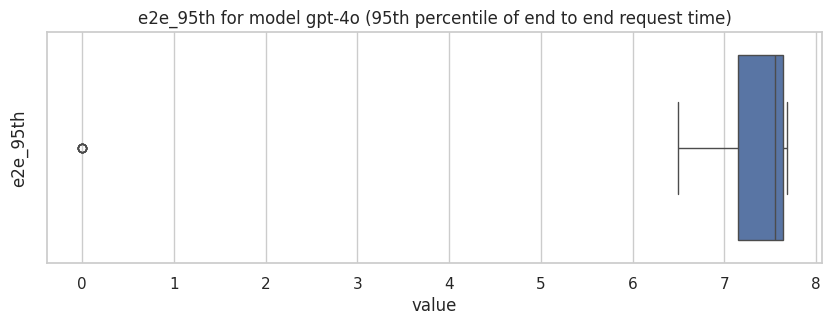

In [103]:
sns.set(style="whitegrid")

for col in cols_to_plot:
    plt.figure(figsize=(10, 3))
    sns.boxplot(x=df1[col])
    plt.title(f'{col} for model {MODEL1} ({metrics_labels[col]})')
    plt.xlabel('value')
    plt.ylabel(col)
    plt.show()

## 6. Second model

### 6.1 Running benchmarks from the second model

In [104]:
os.environ['OPENAI_API_KEY'] = KEY2

In [105]:
print(f"Benchmarks for model {MODEL2}")

Benchmarks for model gpt-4-32k


In [106]:
# With output file generation
OUTPUT_FILE = os.path.join(HOME, RESULTS_DIR, f"benchmarks_{MODEL2_LABEL}_{local_tz}.txt")

command = [
    'python', '-m', 'benchmark.bench', 'load',
    '--deployment', MODEL2,  # Model to use
    '--rate', '15',  # RPM
    '--duration', '180',  # Duration in seconds (should be > 30 secs)
    '--shape', 'custom',  # Custom request shape
    '--context-tokens', '500',  # Context tokens
    '--max-tokens', '500',  # Max tokens
    '--retry', 'exponential',  # Retry
    '--output-format', 'human',  # Output format
    ENDPOINT2  # Model endpoint to use
]

# Running the benchmarks
start = time.time()
now = datetime.datetime.today()
print(f"{now} Running benchmarks for model {MODEL2}...")
result = subprocess.run(command, capture_output=True, text=True)
elapsed = time.time() - start

# Saving the results into a file
with open(OUTPUT_FILE, 'w') as f:
    f.write(result.stdout)

print(f"Benchmark output saved to file {OUTPUT_FILE}")
now = datetime.datetime.today()
print("End:", now)
print("Elapsed time: " + time.strftime(
    "%H:%M:%S.{}".format(str(elapsed % 1)[2:])[:15], time.gmtime(elapsed)))

2024-07-08 12:00:50.619323 Running benchmarks for model gpt-4-32k...
Benchmark output saved to file /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow9/code/Users/seretkow/AOAI benchmarks/results/results_08Jul2024_135656/benchmarks_gpt-4-32k PAYGO_08Jul2024_135656.txt
End: 2024-07-08 12:04:18.718444
Elapsed time: 00:03:28.002542


In [107]:
# Define the columns to read and their corresponding indices in the file
columns = {
    'timestamp': (0, 2),
    'rpm': 3,
    'processing': 5,
    'completed': 7,
    'failures': 9,
    'throttled': 11,
    'requests': 13,
    'tpm': 15,
    'ttft_avg': 17,
    'ttft_95th': 19,
    'tbt_avg': 21,
    'tbt_95th': 23,
    'e2e_avg': 25,
    'e2e_95th': 27,
    'util_avg': 29,
    'util_95th': 31
}

data = {key: [] for key in columns.keys()}

# Reading file
with open(OUTPUT_FILE, 'r') as file:
    for line in file:
        fields = line.strip().split()
        for key, idx in columns.items():
            if isinstance(idx, tuple):
                value = ' '.join(fields[idx[0]:idx[1]])
            else:
                value = fields[idx]
            data[key].append(value)

df2 = pd.DataFrame(data)
df2 = df2.replace('n/a', 0)
int_columns = ['processing', 'completed', 'failures', 'throttled', 'requests']
float_columns = [
    'rpm', 'tpm', 'ttft_avg', 'ttft_95th', 'tbt_avg', 'tbt_95th', 'e2e_avg',
    'e2e_95th',
]
df2[int_columns] = df2[int_columns].astype(int)
df2[float_columns] = df2[float_columns].astype(float)
df2['model'] = MODEL2

In [108]:
df2.shape

(207, 17)

In [109]:
df2

,timestamp,rpm,processing,completed,failures,throttled,requests,tpm,ttft_avg,ttft_95th,tbt_avg,tbt_95th,e2e_avg,e2e_95th,util_avg,util_95th,model
0,2024-07-08 12:00:52,0.0,2,0,0,0,0,0.0,0.000,0.000,0.000,0.000,0.000,0.00,0,0,gpt-4-32k
1,2024-07-08 12:00:53,0.0,2,0,0,0,0,0.0,0.000,0.000,0.000,0.000,0.000,0.00,0,0,gpt-4-32k
2,2024-07-08 12:00:54,0.0,2,0,0,0,0,0.0,0.000,0.000,0.000,0.000,0.000,0.00,0,0,gpt-4-32k
3,2024-07-08 12:00:55,0.0,2,0,0,0,0,0.0,0.000,0.000,0.000,0.000,0.000,0.00,0,0,gpt-4-32k
4,2024-07-08 12:00:56,0.0,3,0,0,0,0,0.0,0.000,0.000,0.000,0.000,0.000,0.00,0,0,gpt-4-32k
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,2024-07-08 12:04:15,8.0,1,42,0,0,42,8024.0,0.499,0.838,0.048,0.062,26.505,41.22,0,0,gpt-4-32k
203,2024-07-08 12:04:16,7.0,1,42,0,0,42,7021.0,0.504,0.850,0.049,0.062,26.505,41.22,0,0,gpt-4-32k
204,2024-07-08 12:04:17,7.0,1,42,0,0,42,7021.0,0.504,0.850,0.049,0.062,26.505,41.22,0,0,gpt-4-32k
205,2024-07-08 12:04:18,7.0,1,42,0,0,42,7021.0,0.504,0.850,0.049,0.062,26.505,41.22,0,0,gpt-4-32k


In [110]:
df2.describe()

,rpm,processing,completed,failures,throttled,requests,tpm,ttft_avg,ttft_95th,tbt_avg,tbt_95th,e2e_avg,e2e_95th,util_avg,util_95th
count,207.000000,207.000000,207.000000,207.0,207.0,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.0,207.0
mean,7.051208,5.507246,19.323671,0.0,0.0,19.323671,7071.739130,0.419000,0.632633,0.044623,0.057082,23.184401,31.806845,0.0,0.0
std,3.149447,1.805788,13.654423,0.0,0.0,13.654423,3158.377974,0.173114,0.390885,0.017956,0.026256,9.231526,14.238872,0.0,0.0
min,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,7.000000,5.000000,7.000000,0.0,0.0,7.000000,7021.000000,0.437500,0.529000,0.048000,0.054000,25.919000,31.476000,0.0,0.0
50%,8.000000,6.000000,19.000000,0.0,0.0,19.000000,8024.000000,0.465000,0.568000,0.050000,0.063000,26.602000,35.619000,0.0,0.0
75%,9.000000,7.000000,32.000000,0.0,0.0,32.000000,9027.000000,0.488000,0.739000,0.054000,0.072000,26.891000,41.570000,0.0,0.0
max,10.300000,9.000000,43.000000,0.0,0.0,43.000000,10375.000000,0.622000,1.502000,0.059000,0.087000,30.383000,42.208000,0.0,0.0


### 6.2 Lineplots using Plotly

In [111]:
df2 = df2.reset_index()

In [112]:
for col in cols_to_plot:
    fig = px.line(
        df2,
        x=df2.index,
        y=df2[col],
        title=f'{col} for model {MODEL2} ({metrics_labels[col]})',
        template="plotly",
    )
    fig.show()
    fig.write_image(os.path.join(HOME, RESULTS_DIR, f"{MODEL2_LABEL}_lineplot_{col}_{local_tz}.jpg"))

### 6.3 Lineplots using Seaborn

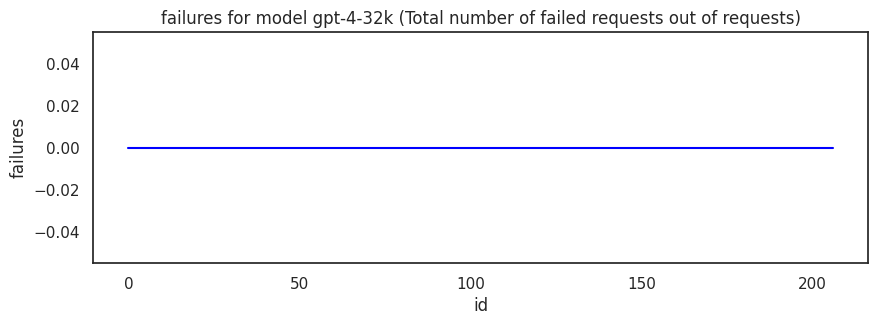

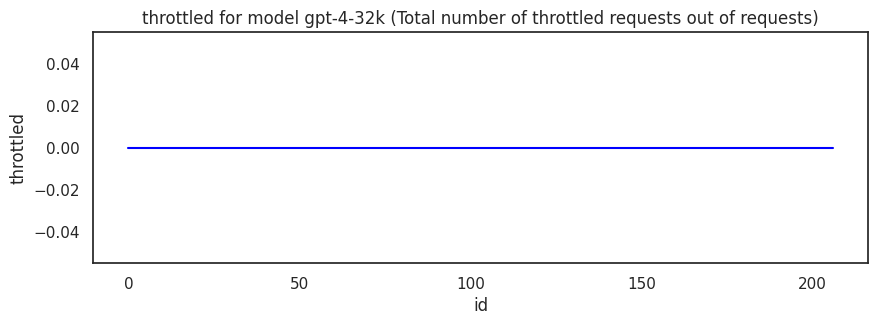

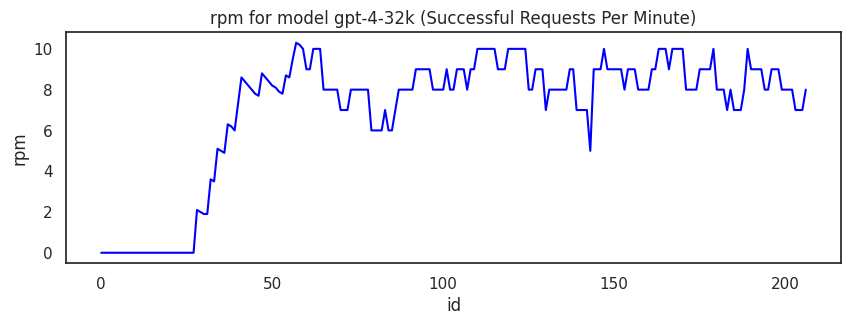

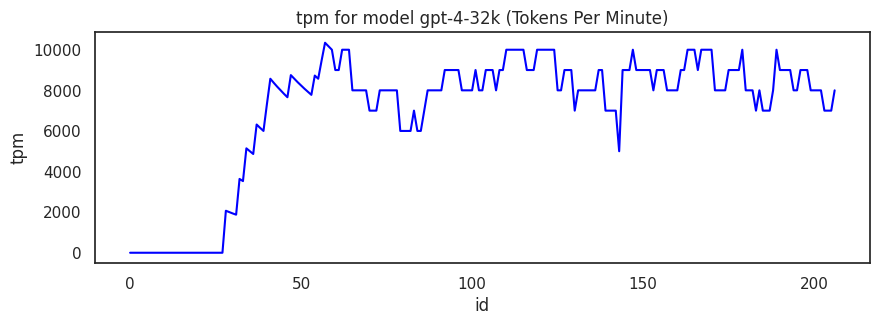

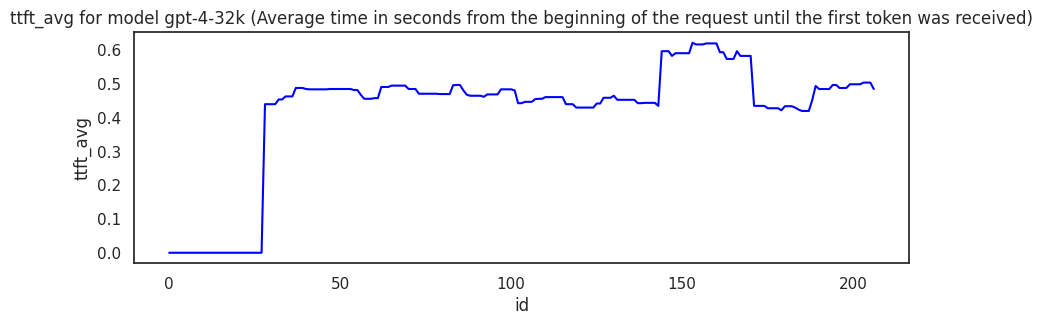

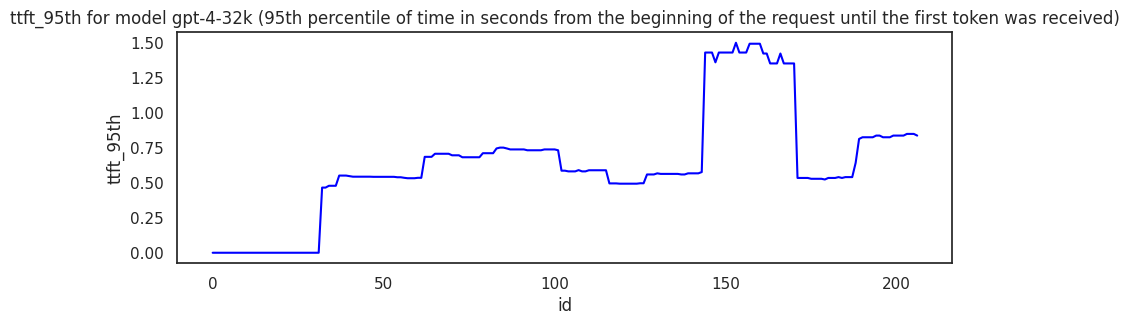

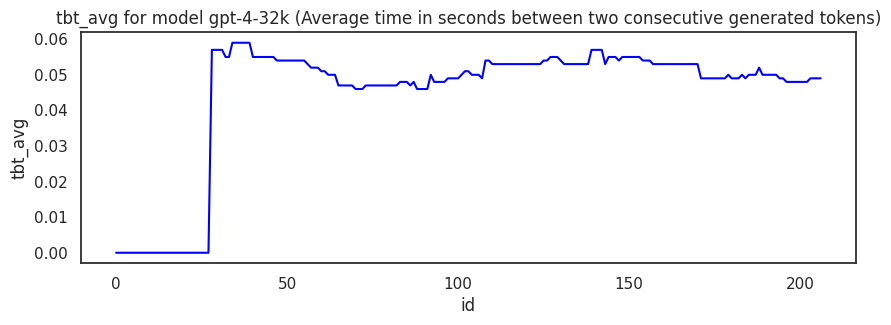

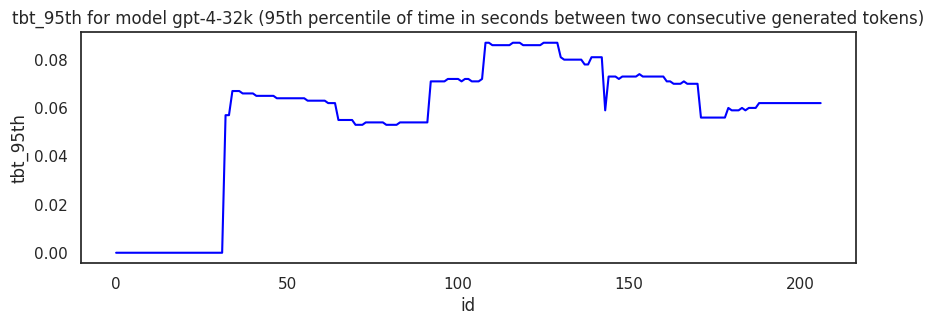

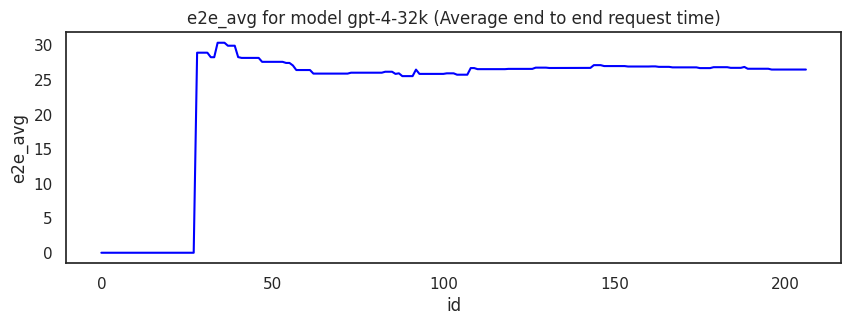

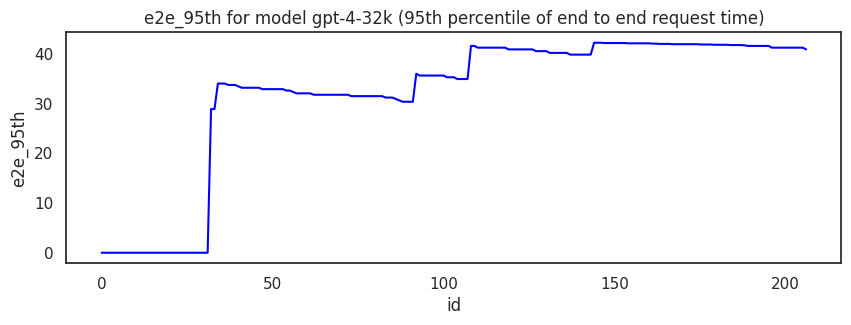

In [113]:
sns.set(style="white")

for col in cols_to_plot:
    plt.figure(figsize=(10, 3))
    sns.lineplot(data=df2, x='index', y=col, color='blue')
    plt.title(f'{col} for model {MODEL2} ({metrics_labels[col]})')
    plt.xlabel('id')
    plt.ylabel(col)
    plt.show()

### 6.4 Boxplots using Plotly

In [114]:
for col in cols_to_plot:
    fig = px.box(df2,
                 y=df2[col],
                 title=f'{col} for model {MODEL2} ({metrics_labels[col]})',
                 template="plotly")
    fig.show()
    fig.write_image(os.path.join(HOME, RESULTS_DIR, f"{MODEL2_LABEL}_boxplot_{col}_{local_tz}.jpg"))

### 6.5 Boxplots using Seaborn

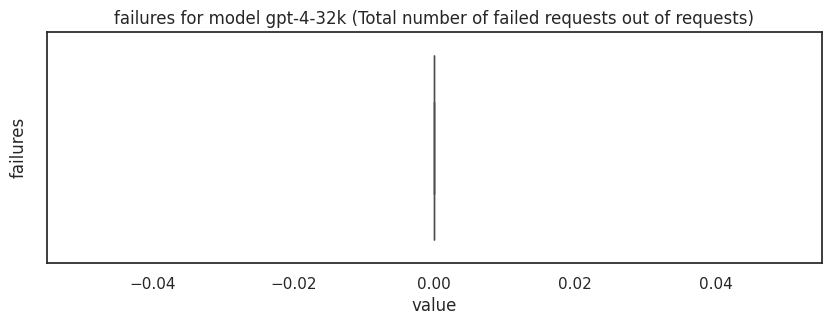

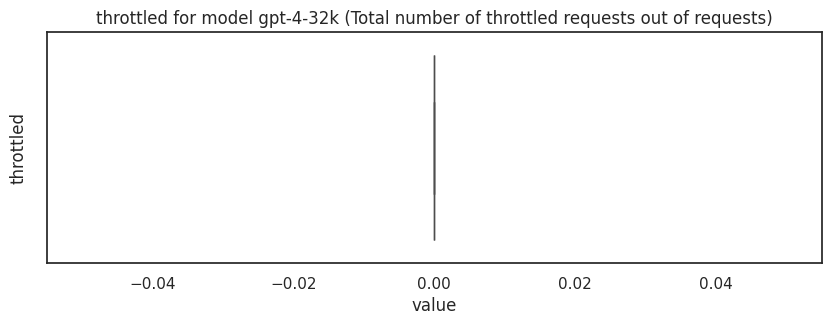

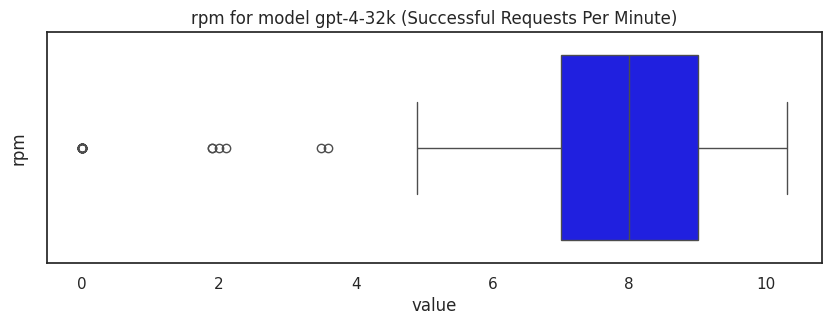

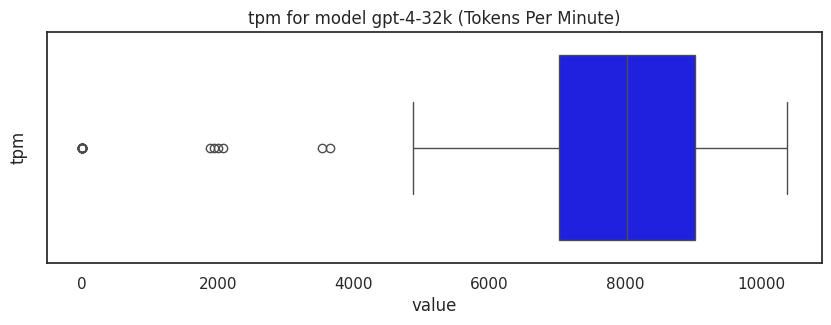

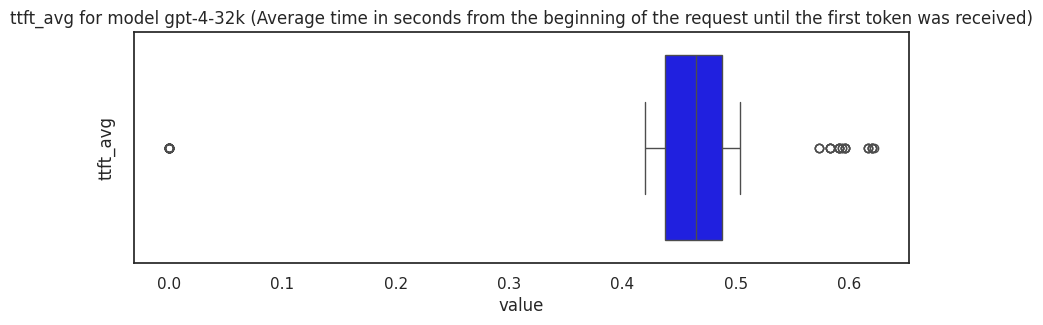

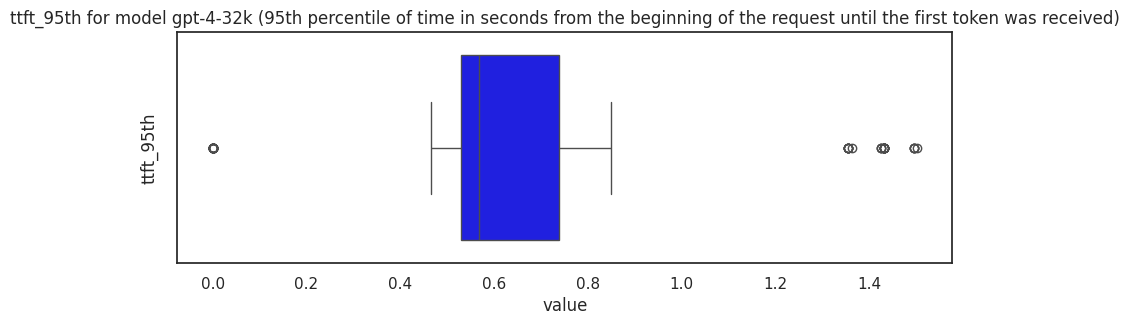

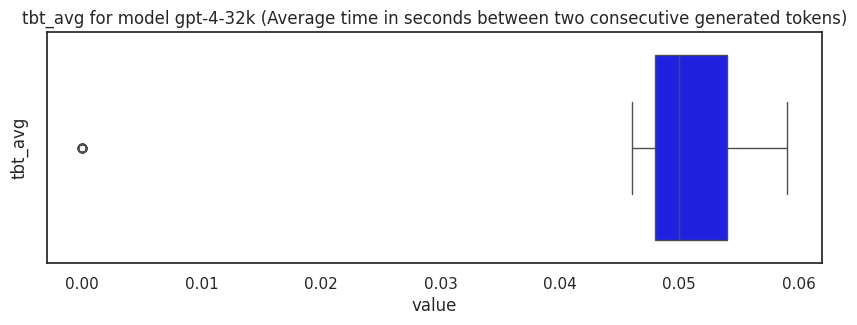

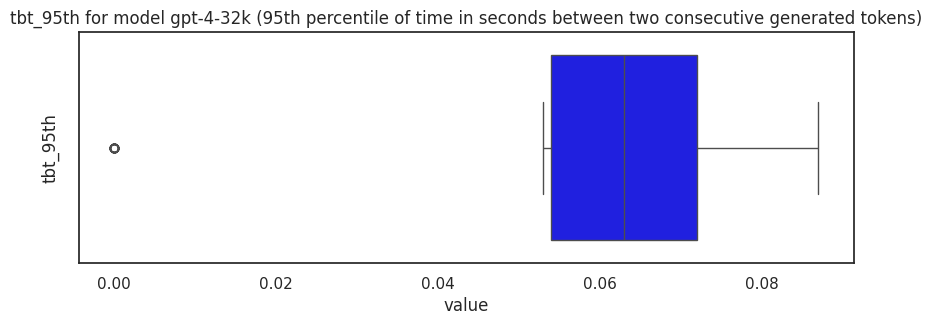

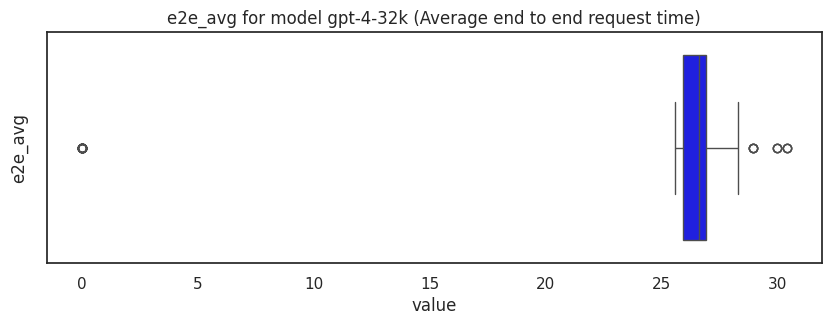

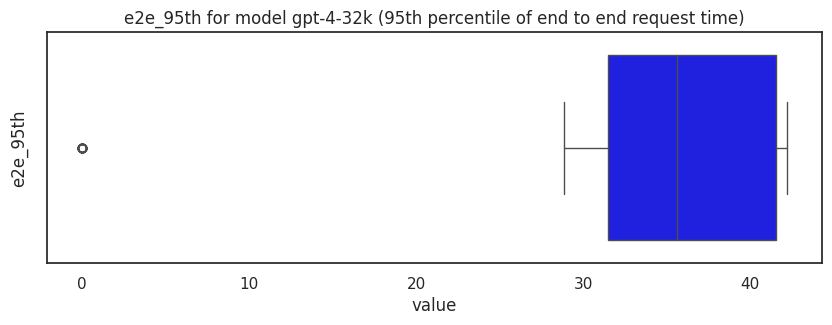

In [115]:
sns.set(style="white")

for col in cols_to_plot:
    plt.figure(figsize=(10, 3))
    sns.boxplot(x=df2[col], color="blue")
    plt.title(f'{col} for model {MODEL2} ({metrics_labels[col]})')
    plt.xlabel('value')
    plt.ylabel(col)
    plt.show()

## 7. Benchmarks comparison results

In [116]:
df1.describe()

,index,rpm,failures,throttled,tpm,ttft_avg,ttft_95th,tbt_avg,tbt_95th,e2e_avg,e2e_95th,util_avg,util_95th
count,186.000000,186.000000,186.0,186.0,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.0,186.0
mean,92.500000,12.439785,0.0,0.0,12491.344086,0.156409,0.251237,0.012043,0.013941,6.236140,7.113452,0.0,0.0
std,53.837719,2.389465,0.0,0.0,2400.524549,0.041416,0.122545,0.002259,0.002739,1.145562,1.354903,0.0,0.0
min,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,46.250000,12.000000,0.0,0.0,12048.000000,0.136000,0.179000,0.012000,0.014000,6.418000,7.145000,0.0,0.0
50%,92.500000,13.000000,0.0,0.0,13052.000000,0.148000,0.232000,0.012000,0.015000,6.458000,7.553000,0.0,0.0
75%,138.750000,13.000000,0.0,0.0,13052.000000,0.175000,0.260000,0.013000,0.015000,6.494000,7.639000,0.0,0.0
max,185.000000,17.100000,0.0,0.0,17212.000000,0.247000,0.581000,0.013000,0.016000,6.587000,7.682000,0.0,0.0


In [117]:
df2.describe()

,index,rpm,processing,completed,failures,throttled,requests,tpm,ttft_avg,ttft_95th,tbt_avg,tbt_95th,e2e_avg,e2e_95th,util_avg,util_95th
count,207.000000,207.000000,207.000000,207.000000,207.0,207.0,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.0,207.0
mean,103.000000,7.051208,5.507246,19.323671,0.0,0.0,19.323671,7071.739130,0.419000,0.632633,0.044623,0.057082,23.184401,31.806845,0.0,0.0
std,59.899917,3.149447,1.805788,13.654423,0.0,0.0,13.654423,3158.377974,0.173114,0.390885,0.017956,0.026256,9.231526,14.238872,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,51.500000,7.000000,5.000000,7.000000,0.0,0.0,7.000000,7021.000000,0.437500,0.529000,0.048000,0.054000,25.919000,31.476000,0.0,0.0
50%,103.000000,8.000000,6.000000,19.000000,0.0,0.0,19.000000,8024.000000,0.465000,0.568000,0.050000,0.063000,26.602000,35.619000,0.0,0.0
75%,154.500000,9.000000,7.000000,32.000000,0.0,0.0,32.000000,9027.000000,0.488000,0.739000,0.054000,0.072000,26.891000,41.570000,0.0,0.0
max,206.000000,10.300000,9.000000,43.000000,0.0,0.0,43.000000,10375.000000,0.622000,1.502000,0.059000,0.087000,30.383000,42.208000,0.0,0.0


### Using Plotly

In [118]:
for col in cols_to_plot:
    combined_df = pd.concat([df1[[col, 'model']], df2[[col, 'model']]])
    fig = px.box(combined_df,
                 x="model",
                 y=col,
                 color='model',
                 title=f"{col} ({metrics_labels[col]})",
                 color_discrete_map={
                     "f'{MODEL1}'": "blue",
                     "f'{MODEL2}'": "green"
                 })
    fig.update_xaxes(title_text="Models",
                     ticktext=[f"{MODEL1}", f"{MODEL2}"])
    fig.update_layout(showlegend=False, template="seaborn")
    fig.show()
    fig.write_image(os.path.join(HOME, RESULTS_DIR, f"{MODEL1_LABEL}_{MODEL2_LABEL}_{col}_{local_tz}.jpg"))

### Using Seaborn

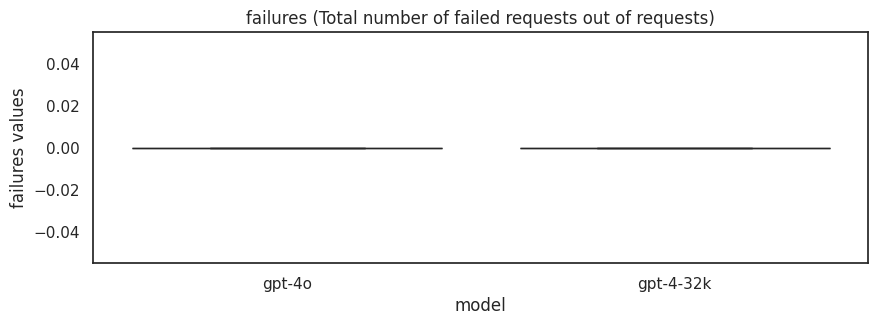

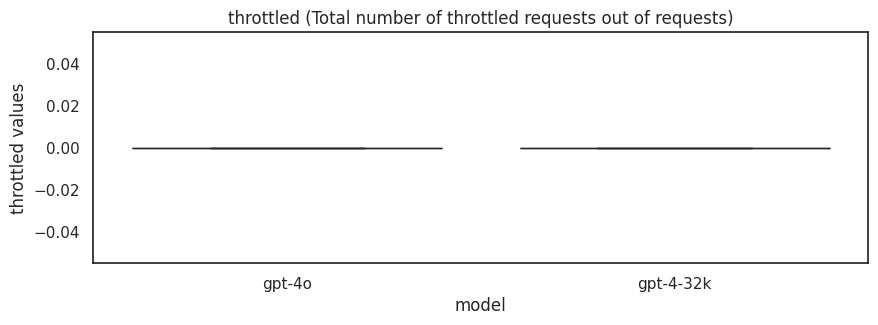

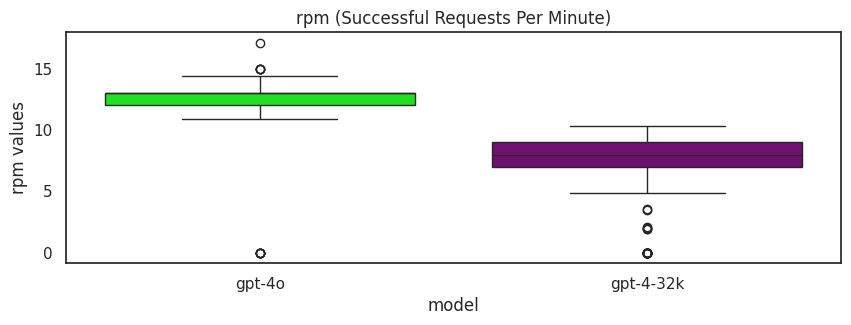

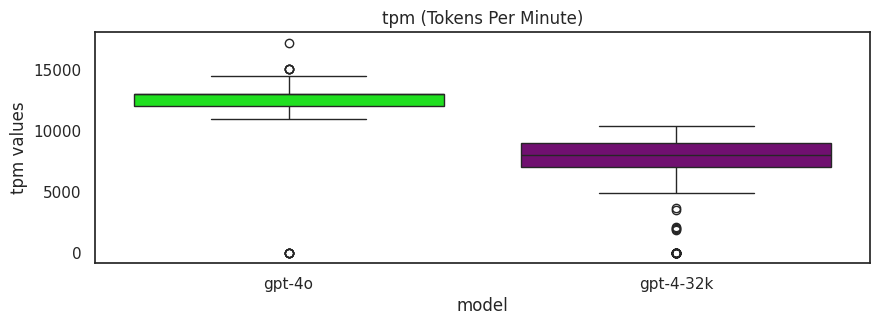

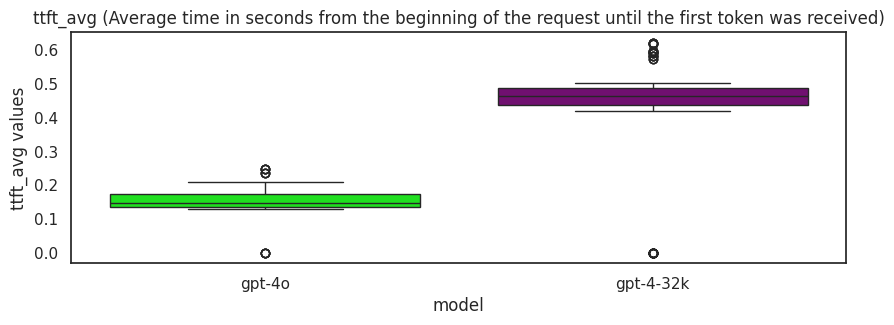

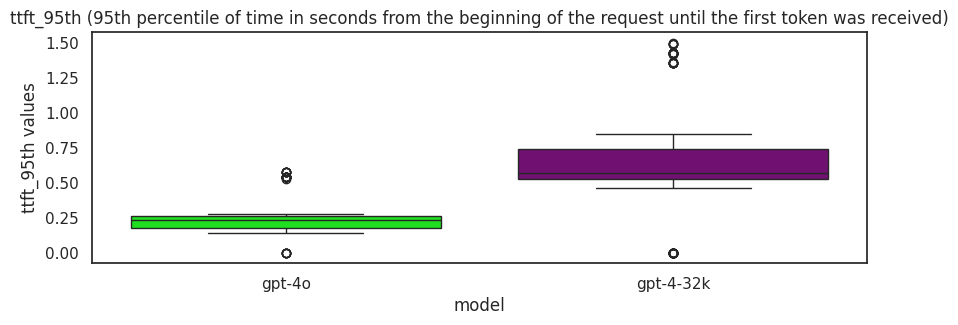

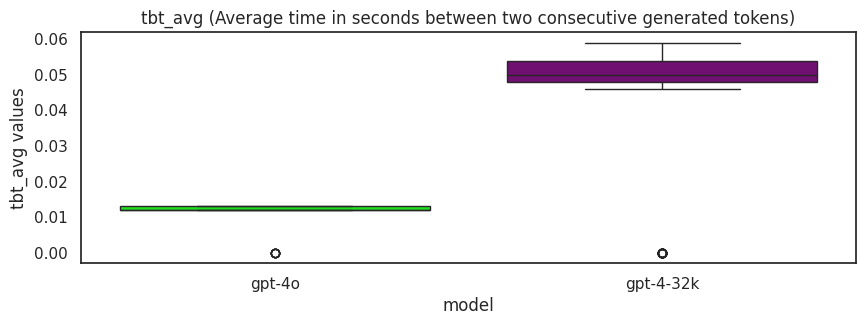

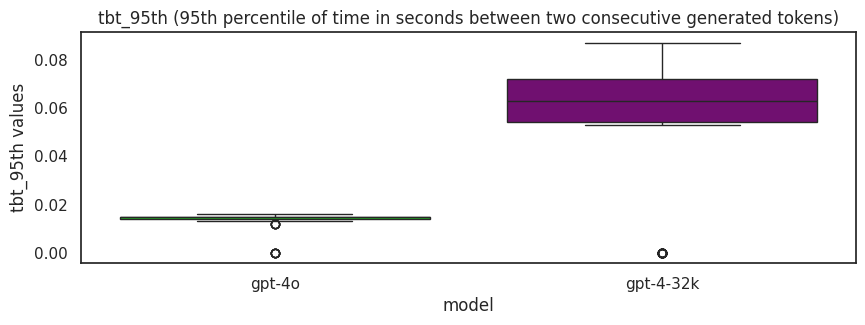

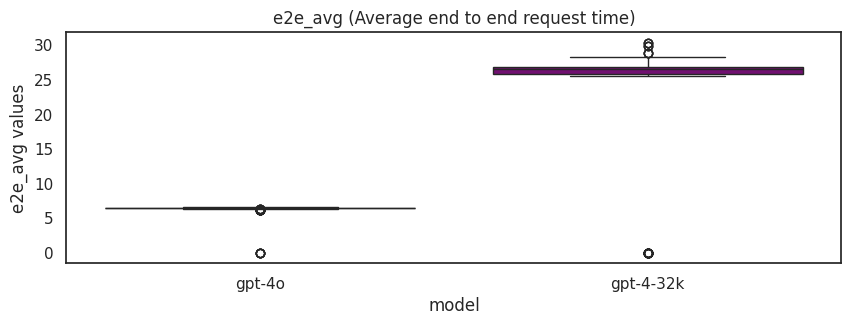

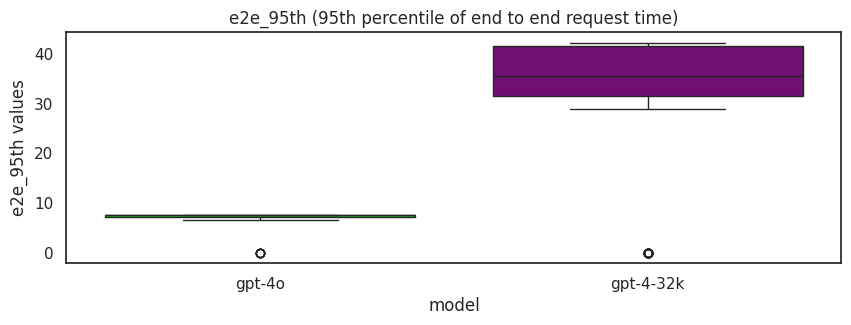

In [119]:
custom_palette = {f"{MODEL1}": 'lime', f"{MODEL2}": 'purple'}

for col in cols_to_plot:
    combined_df = pd.concat([df1[[col, 'model']], df2[[col, 'model']]])
    plt.figure(figsize=(10, 3))
    sns.boxplot(x='model',
                y=col,
                hue='model',
                data=combined_df,
                palette=custom_palette,
                dodge=False,
                legend=False)
    plt.title(f"{col} ({metrics_labels[col]})")
    plt.ylabel(f"{col} values")
    plt.show()

### Excel exports

In [120]:
df1.to_excel(os.path.join(HOME, RESULTS_DIR, f"benchmarks_{MODEL1_LABEL}_{local_tz}.xlsx"))

In [121]:
df2.to_excel(os.path.join(HOME, RESULTS_DIR, f"benchmarks_{MODEL2_LABEL}_{local_tz}.xlsx"))

In [122]:
all_df = pd.concat([df1, df2], ignore_index=True)

all_df.to_excel(
    os.path.join(HOME, RESULTS_DIR, f"benchmarks_{MODEL1_LABEL}_and_{MODEL2_LABEL}_{local_tz}.xlsx"))

## 09. Use Azure OpenAI to analyse the benchmarks results

In [123]:
# Setting up the AOAI client
client = AzureOpenAI(
        api_key=KEY1,
        api_version="2024-02-01",
        base_url=f"{ENDPOINT1}openai/deployments/{MODEL1}",
)

In [124]:
benchmarks_results = os.path.join(HOME, RESULTS_DIR, f"benchmarks_{MODEL1_LABEL}_and_{MODEL2_LABEL}_{local_tz}.xlsx")
df = pd.read_excel(benchmarks_results)

In [125]:
# Prompt
SYSTEM_MSG = "Analyze the following data. This dataset is a benchmarks about two GenAI models.\
You should provide insights for each model and generate a comparative analysis. Give some details in a markdown format:\n\n"

PROMPT = df.to_string(index=False)

In [126]:
# Sending the request
response = client.chat.completions.create(
    model=f"{MODEL2}",
    messages=[
        {"role": "system", "content": SYSTEM_MSG},
        {"role": "user", "content": PROMPT},
    ],
    temperature=0.0,
)

In [127]:
# Print the results
print("\033[1;31;34m")
report = response.choices[0].message.content
print(report)


## Insights for Each Model

### GPT-4o

1. **Initial Performance**:
   - The model starts with no requests and no completions for the first few seconds.
   - Initial RPM (Requests Per Minute) is 0.0, indicating no activity.

2. **Performance Metrics**:
   - **RPM**: Peaks at 17.1 and then stabilizes around 13.0-15.0.
   - **TPM (Transactions Per Minute)**: Starts at 0 and increases steadily, reaching up to 13052.
   - **TTFT (Time to First Transaction)**: Average around 0.247 seconds initially, then decreases to around 0.135 seconds.
   - **TBT (Time Between Transactions)**: Consistently around 0.012-0.013 seconds.
   - **E2E (End-to-End Time)**: Starts at 6.488 seconds and decreases to around 6.424 seconds.
   - **Utilization**: Remains at 0 throughout the dataset, indicating no throttling or failures.

3. **Completion and Requests**:
   - The number of completed requests increases steadily, reaching up to 43 by the end of the dataset.
   - The number of requests also increases in ta

In [128]:
report_file = os.path.join(HOME, RESULTS_DIR, f"report_{MODEL1_LABEL}_{MODEL2_LABEL}_{local_tz}.md")

with open(report_file, "w") as file:
    file.write(report)

print(f"Report saved to {report_file}")

Report saved to /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow9/code/Users/seretkow/AOAI benchmarks/results/results_08Jul2024_135656/report_gpt-4o PAYGO_gpt-4-32k PAYGO_08Jul2024_135656.md


## 10. Saved results

In [129]:
os.chdir(HOME)

In [130]:
excel_link = FileLink(path=os.path.join(RESULTS_DIR, f"benchmarks_{MODEL1_LABEL}_and_{MODEL2_LABEL}_{local_tz}.xlsx"))
excel_link

/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow9/code/Users/seretkow/AOAI benchmarks/results/results_08Jul2024_135656/benchmarks_gpt-4o PAYGO_and_gpt-4-32k PAYGO_08Jul2024_135656.xlsx

In [131]:
!ls $RESULTS_DIR/*.* -lt

-rwxrwxrwx 1 root root  3253 Jul  8 12:04 'results/results_08Jul2024_135656/report_gpt-4o PAYGO_gpt-4-32k PAYGO_08Jul2024_135656.md'
-rwxrwxrwx 1 root root 34420 Jul  8 12:04 'results/results_08Jul2024_135656/benchmarks_gpt-4o PAYGO_and_gpt-4-32k PAYGO_08Jul2024_135656.xlsx'
-rwxrwxrwx 1 root root 20105 Jul  8 12:04 'results/results_08Jul2024_135656/benchmarks_gpt-4-32k PAYGO_08Jul2024_135656.xlsx'
-rwxrwxrwx 1 root root 18858 Jul  8 12:04 'results/results_08Jul2024_135656/benchmarks_gpt-4o PAYGO_08Jul2024_135656.xlsx'
-rwxrwxrwx 1 root root 21295 Jul  8 12:04 'results/results_08Jul2024_135656/gpt-4o PAYGO_gpt-4-32k PAYGO_e2e_95th_08Jul2024_135656.jpg'
-rwxrwxrwx 1 root root 19851 Jul  8 12:04 'results/results_08Jul2024_135656/gpt-4o PAYGO_gpt-4-32k PAYGO_e2e_avg_08Jul2024_135656.jpg'
-rwxrwxrwx 1 root root 24542 Jul  8 12:04 'results/results_08Jul2024_135656/gpt-4o PAYGO_gpt-4-32k PAYGO_tbt_95th_08Jul2024_135656.jpg'
-rwxrwxrwx 1 root root 25342 Jul  8 12:04 'results/results_08Jul2024

In [132]:
output_filename = ZIP_DIR + '/archivezip_' + '/'.join(RESULTS_DIR.split('/')[1:])
shutil.make_archive(output_filename, 'zip', RESULTS_DIR)

print(f"Directory {RESULTS_DIR} has been zipped to {output_filename}.zip")

Directory results/results_08Jul2024_135656 has been zipped to zip/archivezip_results_08Jul2024_135656.zip


In [133]:
zipfile_link = FileLink(f"{output_filename}.zip")
zipfile_link

/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow9/code/Users/seretkow/AOAI benchmarks/zip/archivezip_results_08Jul2024_135656.zip

## 11. Post Processing (optional)

In [134]:
# Delete the dir results
#shutil.rmtree(RESULTS_DIR)